The work in this notebook is based on [this discussion post](https://www.kaggle.com/competitions/playground-series-s4e7/discussion/518760) by AmbrosM. I've added 
* Cross-validation
* New features
* New hyperparameters

In [1]:
!pip install -q scikit-learn==1.4 && pip install -q --no-deps scikeras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import keras
import gc

2024-07-22 07:34:06.398658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 07:34:06.398789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 07:34:06.544259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90

N_EPOCHS = 25
LEARNING_RATE = 0.005
BATCH_SIZE = 2048
EVAL_BATCH_SIZE = 65536

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col='id')
original = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv', index_col='id')

In [5]:
train = pd.concat([train, original]).reset_index(drop=True) 
train = train.drop_duplicates(keep="last").reset_index(drop=True)

In [6]:
train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test], axis=0)

In [7]:
# Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution | Beware of data leakage
combined['Previously_Insured_Annual_Premium'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Annual_Premium'].astype(str))[0] 
combined['Previously_Insured_Vehicle_Age'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vehicle_Age'].astype(str))[0]
combined['Previously_Insured_Vehicle_Damage'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vehicle_Damage'].astype(str))[0] 
combined['Previously_Insured_Vintage'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vintage'].astype(str))[0] 

train = combined[combined['is_train'] == 1].drop(columns='is_train')
test = combined[combined['is_train'] == 0].drop(columns=['is_train', TARGET])

del combined

In [8]:
X = train.drop(columns=TARGET)
y = train[TARGET].astype(np.int8)

In [9]:
ohe_columns = [
    'Gender',
    'Region_Code',
    'Vehicle_Age',
    'Vehicle_Damage',
    'Policy_Sales_Channel',
    'Vintage',
    'Previously_Insured_Vehicle_Age',
    'Previously_Insured_Vehicle_Damage'
]
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=True, dtype=np.float32, max_categories=200, handle_unknown='ignore'), ohe_columns),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), ['Annual_Premium']),
        ],
        remainder=make_pipeline(FunctionTransformer(lambda X: X.astype(np.float32)), StandardScaler(copy=False))
    )
)

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(test)

del train, test, pipeline
gc.collect()

81

In [10]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs, temp_test_pred_probs
            gc.collect()
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')
        
        return oof_pred_probs, scores
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        sub['id'] = sub['id']
        sub[TARGET] = test_pred_probs[:, 1]
        # Referencee https://www.kaggle.com/code/paddykb/a-glitch-in-the-insurance-matrix
        INPUT_DIR = Path('/kaggle/input/playground-series-s4e7')
        train_data = pd.read_csv(INPUT_DIR / 'train.csv')
        test_data = pd.read_csv(INPUT_DIR / 'test.csv')
        orig_data = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
        features = sorted(set(test_data.columns) - set(['id']))
        train_data.merge(orig_data, on=features).filter(['Response_x', 'Response_y']).value_counts().reset_index()
        override_sub = test_data.merge(orig_data.drop(columns=['id']), on=features).assign(override=lambda x: np.where(x['Response'] == 0, 1, 0)).filter(['id', 'override']).groupby(['id'], as_index=False).agg(override=('override', 'mean'))
        sub.merge(override_sub, how='outer').assign(Response=lambda x: np.where(x['override'].isna(), x['Response'], x['override'])).filter(['id', 'Response']).to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [11]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(52, kernel_initializer='truncated_normal', activation='silu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(660, kernel_initializer='truncated_normal', activation='silu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(508, kernel_initializer='truncated_normal', activation='silu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, kernel_initializer='truncated_normal', activation='sigmoid'))
    return model

In [12]:
model = KerasClassifier(
    get_model,
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name='auc')],
    optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    validation_batch_size=EVAL_BATCH_SIZE,
    epochs=N_EPOCHS, 
    verbose=0,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_auc', patience=3, factor=0.3),
        keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
    ]
)

In [13]:
trainer = Trainer(model)
oof_pred_probs, scores = trainer.fit_predict(X, y, X_test)

Training KerasClassifier


--- Fold 1 - AUC: 0.88830



--- Fold 2 - AUC: 0.88821



--- Fold 3 - AUC: 0.88837



--- Fold 4 - AUC: 0.88854



--- Fold 5 - AUC: 0.88861


------ Average AUC:      0.88841 ± 0.00015




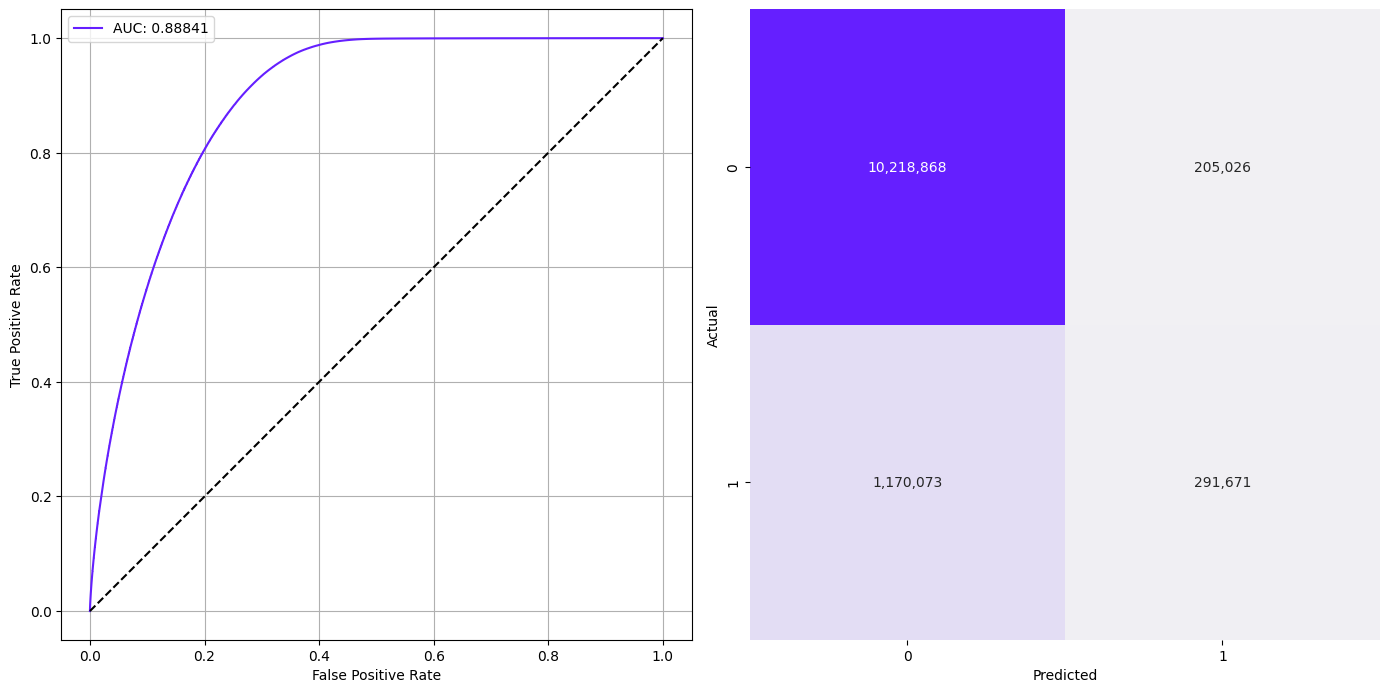

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()